# Predicting Flight Delay

Problem Set-up:
We define a delayed flight to be one that is delayed by >= 15 minutes. 
The prediction problem is to train a model that can classify flights, to predict if they will or will not be delayed.

Use case:
- The idea is that this model would be useful to choosing airlines, flightpaths, airports, at the time of booking, relatively in advance of the scheduled departure (days, weeks, months ahead of time). Therefore, the prediction problem will focus on features that can be known in advance, rather than predicting using day-off features like weather and previous flights from that day. 

Notes:
- We restrict the analysis to relatively large airport, those with more than 20 (domestic) flights a day

# This notebook: more features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

# Create separate models to predict for each airport 

Motivation:
The weights that should eb put on features (e.g. airlines) may differ depending on the airport (see e.g. NB 4B) since different airports can have different environments (e.g. San Diego and Chicago winters are very different; American Airlines is better in Tuscon than in Anchorage.

In [23]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [24]:
# Import custom code
from flightdelay.fld import io as flio

# Load data

In [25]:
airlines_df, airports_df, flights_df = flio.load_data()

In [26]:
# Filter data to keys of interest
keys = ['AIRLINE', 'FLIGHT_NUMBER','ORIGIN_AIRPORT','DEPARTURE_DELAY']
flights_df = flights_df[keys]

# Remove airports with less than a certain number of flights

In [27]:
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

In [28]:
# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]

In [29]:
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

# Remove cancelled flights

In [30]:
flights_df = flights_df.dropna()

In [31]:
flights_df.head(100)

,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DEPARTURE_DELAY
0,AS,98,ANC,-11.0
1,AA,2336,LAX,-8.0
2,US,840,SFO,-2.0
3,AA,258,LAX,-5.0
4,AS,135,SEA,-1.0
5,DL,806,SFO,-5.0
6,NK,612,LAS,-6.0
7,US,2013,LAX,14.0
8,AA,1112,SFO,-11.0
9,DL,1173,LAS,3.0


# Make unique identifier for each flight

In [32]:
flights_df['FLIGHT_NUMBER'] = flights_df['FLIGHT_NUMBER'].astype(str)
flnums = flights_df[['ORIGIN_AIRPORT','AIRLINE','FLIGHT_NUMBER']].fillna('').sum(axis=1)
delays = flights_df['DEPARTURE_DELAY'].values > 15

In [33]:
unique_flnum, flnum_idx = np.unique(flnums,return_inverse=True)

In [34]:
N_uniqueflnum = len(unique_flnum)
uniquefl_idxs = [0]*N_uniqueflnum
uniquefl_delayp = [0]*N_uniqueflnum
for i in range(N_uniqueflnum):
    uniquefl_delayp[i] = np.mean(delays[flnum_idx==i])

# Make train and val set

In [35]:
N_flights = len(flnums)
N_train = int(N_flights*.7)

np.random.seed(0)
flight_take_idx = np.random.permutation(np.arange(N_flights))

flnums_train = flnums[flight_take_idx[:N_train]].values
flnums_val = flnums[flight_take_idx[N_train:]].values

In [36]:
y_train = delays[flight_take_idx[:N_train]]
y_val = delays[flight_take_idx[N_train:]]

# Make dict for prediction

In [37]:
from collections import defaultdict
flnum_pred_dict = defaultdict(bool,zip(unique_flnum,np.array(uniquefl_delayp)>.5))
#flnum_pred_dict6 = defaultdict(bool,zip(unique_flnum,np.array(uniquefl_delayp)>.9))

In [43]:
print(unique_flnum[0],uniquefl_delayp[0])

ABQAA1024 0.27380952381


# Predict delay in validation set

In [17]:
N_val = len(y_val)
val_pred = [0]*N_val
for i in range(N_val):
    val_pred[i] = flnum_pred_dict[flnums_val[i]]

In [18]:
confusion_matrix(y_val, val_pred)

array([[1274510,   19509],
       [ 280937,    5025]])

In [19]:
print('accuracy:',1-sum(abs(val_pred-y_val))/N_val)

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  if __name__ == '__main__':


accuracy: 0.809842017088


0.504904675796


(0, 1)

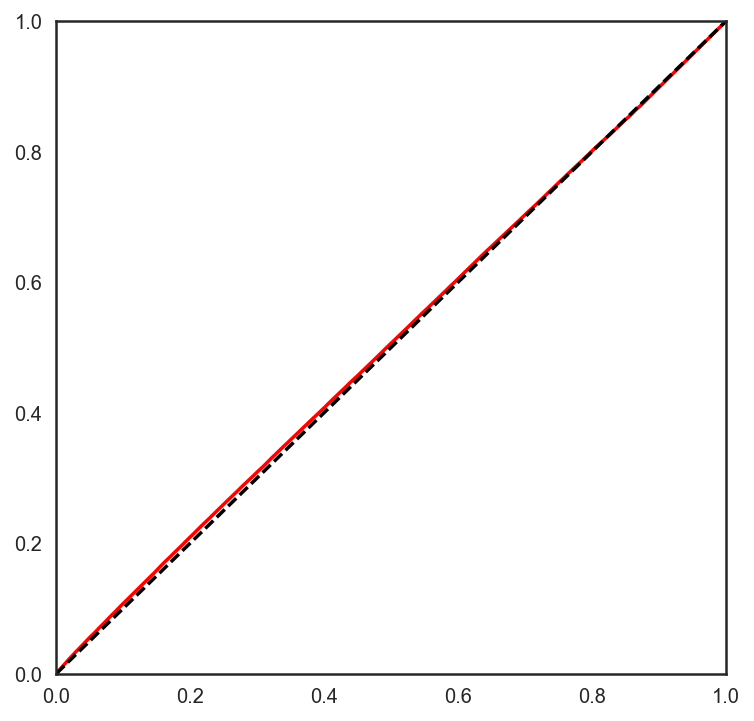

In [22]:
flnum_predp_dict = defaultdict(bool,zip(unique_flnum,uniquefl_delayp))
val_predp = [0]*N_val
for i in range(N_val):
    val_predp[i] = flnum_predp_dict[flnums_val[i]]

fpr, tpr, th = roc_curve(y_val, val_predp)
print(roc_auc_score(y_val, val_predp))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))